In [48]:
# ========================================
# Higgs discovery – ATLAS Open Data (Run 2)
# Channel: H → ZZ → 4 leptons
# ========================================

import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from glob import glob

plt.style.use(hep.style.ATLAS)

In [49]:
files = sorted(glob("data/ODEO_FEB2025_v0_exactly4lep_data*_period*.exactly4lep.root"))

In [50]:
import uproot

f = uproot.open("data/ODEO_FEB2025_v0_exactly4lep_data16_periodA.exactly4lep.root")
print(f.keys())
tree = f["analysis"]
print(tree.keys())


['analysis;1']
['num_events', 'sum_of_weights', 'sum_of_weights_squared', 'category', 'TriggerMatch_DILEPTON', 'ScaleFactor_MLTRIGGER', 'ScaleFactor_PILEUP', 'ScaleFactor_FTAG', 'mcWeight', 'xsec', 'filteff', 'kfac', 'channelNumber', 'eventNumber', 'runNumber', 'trigML', 'trigP', 'trigDT', 'trigT', 'trigE', 'trigDM', 'trigDE', 'trigM', 'trigMET', 'ScaleFactor_BTAG', 'ScaleFactor_JVT', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_e', 'jet_btag_quantile', 'jet_jvt', 'largeRJet_n', 'largeRJet_pt', 'largeRJet_eta', 'largeRJet_phi', 'largeRJet_e', 'largeRJet_m', 'largeRJet_D2', 'jet_pt_jer1', 'jet_pt_jer2', 'ScaleFactor_ELE', 'ScaleFactor_MUON', 'ScaleFactor_LepTRIGGER', 'ScaleFactor_MuTRIGGER', 'ScaleFactor_ElTRIGGER', 'lep_n', 'lep_type', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_e', 'lep_charge', 'lep_ptvarcone30', 'lep_topoetcone20', 'lep_z0', 'lep_d0', 'lep_d0sig', 'lep_isTightID', 'lep_isMediumID', 'lep_isLooseID', 'lep_isTightIso', 'lep_isLooseIso', 'lep_isTrigMatched', 'ScaleFactor_PHOT

In [54]:
arrays = uproot.concatenate(
    {f: "analysis" for f in files},
    [
        "lep_pt", "lep_eta", "lep_phi", "lep_e", "lep_type", "lep_n",
        "mcWeight", "eventNumber"
    ],
    library="ak"
)

print("Events loaded:", len(arrays))

Events loaded: 1362611


In [55]:
mask_4lep = arrays["lep_n"] == 4
lep_pt = arrays["lep_pt"][mask_4lep]
lep_eta = arrays["lep_eta"][mask_4lep]
lep_phi = arrays["lep_phi"][mask_4lep]
lep_e = arrays["lep_e"][mask_4lep]
lep_type = arrays["lep_type"][mask_4lep]

In [56]:
# Formule 4-vectors: m4l² = (ΣE)² - (Σp_x)² - (Σp_y)² - (Σp_z)²
px = lep_pt * np.cos(lep_phi)
py = lep_pt * np.sin(lep_phi)
pz = lep_pt * np.sinh(lep_eta)

m4l = np.sqrt(
    np.maximum(
        0,
        (ak.sum(lep_e, axis=1))**2
        - (ak.sum(px, axis=1))**2
        - (ak.sum(py, axis=1))**2
        - (ak.sum(pz, axis=1))**2
    )
)

In [57]:
mask_4mu = ak.all(abs(lep_type) == 13, axis=1)
mask_4e = ak.all(abs(lep_type) == 11, axis=1)
mask_2e2mu = ~(mask_4mu | mask_4e)

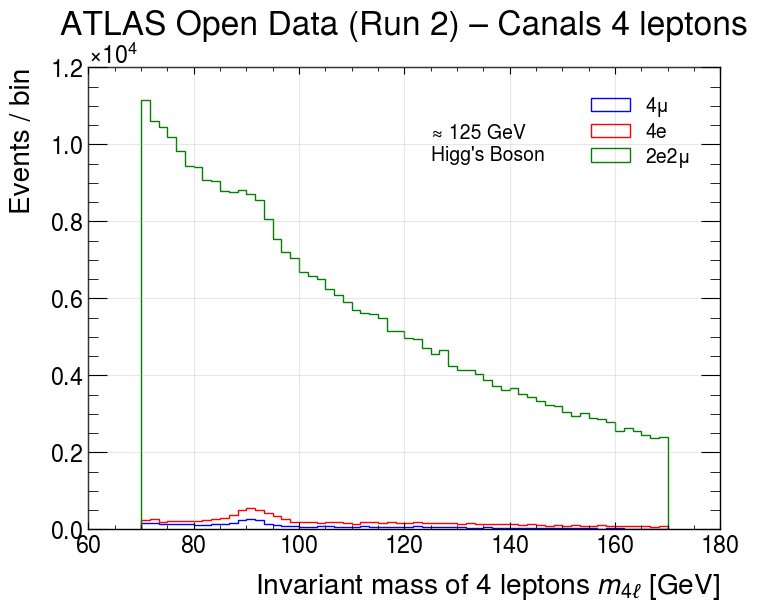

In [58]:
plt.figure(figsize=(8,6))
plt.hist(m4l[mask_4mu], bins=60, range=(70, 170), histtype='step', color='blue', label='4μ')
plt.hist(m4l[mask_4e], bins=60, range=(70, 170), histtype='step', color='red', label='4e')
plt.hist(m4l[mask_2e2mu], bins=60, range=(70, 170), histtype='step', color='green', label='2e2μ')

plt.xlabel("Invariant mass of 4 leptons $m_{4\\ell}$ [GeV]")
plt.ylabel("Events / bin")
plt.title("ATLAS Open Data (Run 2) – Canals 4 leptons")
plt.legend()
plt.grid(alpha=0.3)
plt.text(125, plt.ylim()[1]*0.8, "≈ 125 GeV\nHigg's Boson", color="black")
plt.show()

# Higgs Peak

In [87]:
import numpy
import scipy
print("numpy:", numpy.__version__)
print("scipy:", scipy.__version__)


numpy: 1.26.4
scipy: 1.13.1


In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [89]:

values = ak.to_numpy(m4l)
values = values[(values > 80) & (values < 170)]  # rango razonable

bins = np.linspace(80, 170, 90)
y, bin_edges = np.histogram(values, bins=bins)
x = 0.5 * (bin_edges[1:] + bin_edges[:-1])

In [90]:
def background(x, a, b):
    return a * np.exp(-b * x)

def signal(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

def total(x, a, b, A, mu, sigma):
    return background(x, a, b) + signal(x, A, mu, sigma)


In [91]:
p0 = [1e4, 0.015, 200, 125, 2]
bounds = ([0, 0, 0, 110, 0.5], [np.inf, 1, np.inf, 140, 10])

params, cov = curve_fit(total, x, y, p0=p0, bounds=bounds, maxfev=50000)
a, b, A, mu, sigma = params

print(f"""
setting parameters:
  background: a = {a:.2e}, b = {b:.3f}
  signal (Higgs): A = {A:.1f}, μ = {mu:.2f} GeV, σ = {sigma:.2f} GeV
""")


setting parameters:
  background: a = 2.36e+04, b = 0.017
  signal (Higgs): A = 57.4, μ = 127.53 GeV, σ = 0.58 GeV



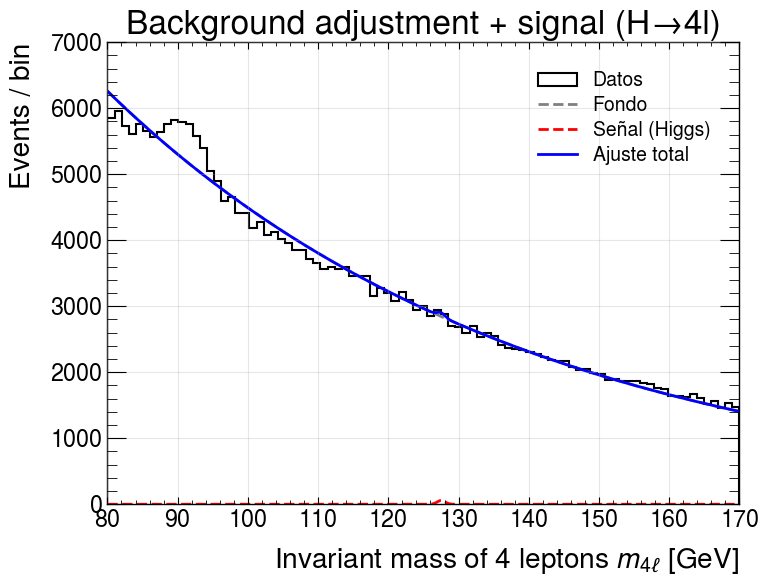

In [92]:
plt.figure(figsize=(8,6))
plt.hist(values, bins=bins, histtype="step", color="black", label="Datos", linewidth=1.5)
xfit = np.linspace(80, 170, 500)
#xdata = 0.5 * (bin_edges[1:] + bin_edges[:-1]) 
plt.plot(xfit, background(xfit, a, b), "--", color="gray", label="Fondo")
plt.plot(xfit, signal(xfit, A, mu, sigma), "--", color="red", label="Señal (Higgs)")
plt.plot(xfit, total(xfit, a, b, A, mu, sigma), "-", color="blue", label="Ajuste total")

plt.xlabel("Invariant mass of 4 leptons $m_{4\\ell}$ [GeV]")
plt.ylabel("Events / bin")
plt.title("Background adjustment + signal (H→4l)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

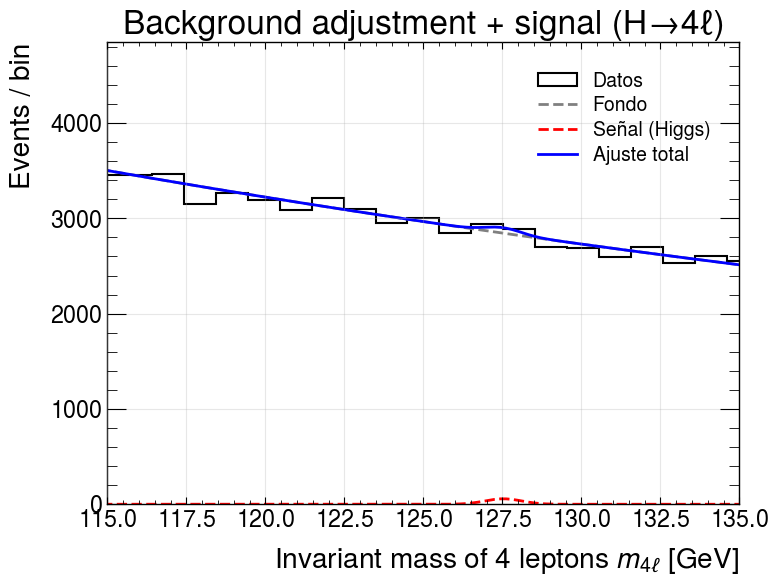

In [93]:

plt.figure(figsize=(8,6))
plt.hist(values, bins=bins, histtype="step", color="black", label="Datos", linewidth=1.5)

xfit = np.linspace(80, 170, 500)
xdata = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.plot(xfit, background(xfit, a, b), "--", color="gray", label="Fondo")
plt.plot(xfit, signal(xfit, A, mu, sigma), "--", color="red", label="Señal (Higgs)")
plt.plot(xfit, total(xfit, a, b, A, mu, sigma), "-", color="blue", label="Ajuste total")

plt.xlabel("Invariant mass of 4 leptons $m_{4\\ell}$ [GeV]")
plt.ylabel("Events / bin")
plt.title("Background adjustment + signal (H→4ℓ)")
plt.legend()
plt.grid(alpha=0.3)

# 🔎 Zoom en la región del Higgs
plt.xlim(115, 135)
plt.ylim(0, np.max(y[(xdata>115)&(xdata<135)])*1.4)
#plt.ylim(0, np.max(y[(x>115)&(x<135)])*1.4)

plt.show()


# Only run this if you finished all

In [76]:
import numpy as np

a=2.36e+04
b=0.017
A=57.4
mu=127.53
sigma=0.58

def background(x): return a * np.exp(-b * x)
def signal(x): return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

x = np.linspace(mu-10, mu+10, 10001)
dx = x[1]-x[0]

for nsig in [1.0, 1.5, 2.0, 3.0]:
    lo, hi = mu - nsig*sigma, mu + nsig*sigma
    xi = x[(x>=lo)&(x<=hi)]
    S = np.sum(signal(xi))*dx
    B = np.sum(background(xi))*dx
    print(f"±{nsig}σ: {lo:.2f}-{hi:.2f} GeV -> S={S:.2f}, B={B:.2f}, S/B={S/B:.3f}, S/sqrt(B)={S/np.sqrt(B):.3f}")


±1.0σ: 126.95-128.11 GeV -> S=57.04, B=3137.40, S/B=0.018, S/sqrt(B)=1.018
±1.5σ: 126.66-128.40 GeV -> S=72.34, B=4703.50, S/B=0.015, S/sqrt(B)=1.055
±2.0σ: 126.37-128.69 GeV -> S=79.67, B=6269.71, S/B=0.013, S/sqrt(B)=1.006
±3.0σ: 125.79-129.27 GeV -> S=83.23, B=9402.63, S/B=0.009, S/sqrt(B)=0.858
